### Imports and config

In [134]:
%matplotlib inline

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.dates import DateFormatter
from osgeo import gdal
from scipy.interpolate import make_interp_spline, BSpline

matplotlib.rc('figure', dpi=150)
plt.rc('axes.formatter', useoffset=False)

transition_cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'orange'])

### Read and clean data

In [128]:
df = pd.read_csv(
    "data_github/sensitivity_data/full_sensitivity_analysis.csv",
    usecols=[1, 2, 3, 4, 5, 6],
)
# df = df[df.index <= 1104] # only need for this partial subset
# df.insert(0,'datetime',pd.to_datetime(df['riv_datetime'],format='%Y%m%d%H'))
df.index = pd.to_datetime(df["riv_datetime"], format="%Y%m%d%H")
df.index = df.index.rename("datetime")
df["surge_h"] = df["surge_h"] * 0.1
# df = df.copy()[df["surge_h"] >= 1.1]

df["n_coastal_norm"] = 100 * df["n_coastal"] / df["n_coastal"].max()
df["n_hydro_norm"] = 100 * df["n_hydro"] / df["n_hydro"].max()
df["n_trans_norm"] = 100 * df["n_trans"] / df["n_trans"].max()

df = df[df.surge_h >= 1.1]

df_hi_res = df.copy()

# filter surge heights to make plot easier to read
df = df[
    (df.surge_h == 1.1)
    | (df.surge_h == 1.5)
    | (df.surge_h == 2)
    | (df.surge_h == 2.5)
    | (df.surge_h == 3)
    | (df.surge_h == 3.5)
]


### Plots

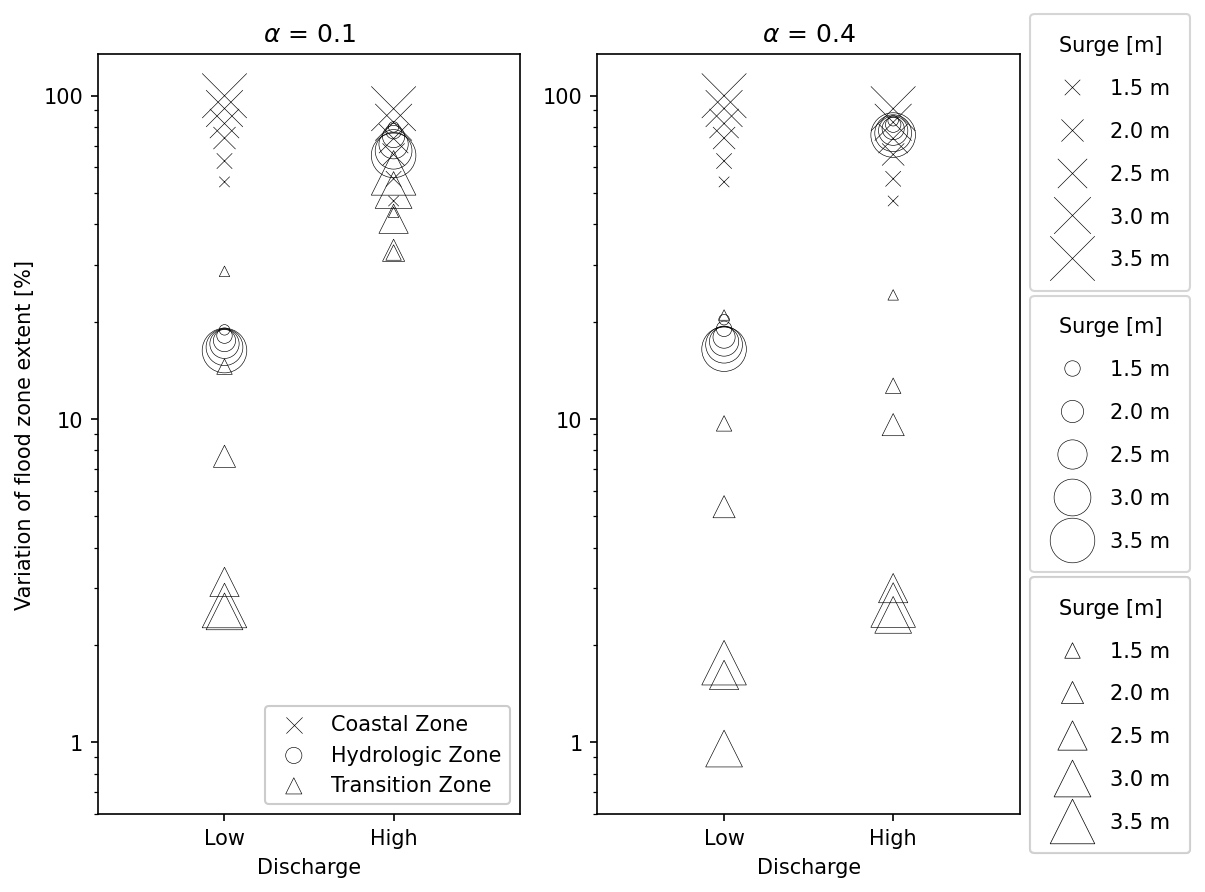

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(7, 6))

# y-axis is zone's area as a percentage of its max value among all scenarios
datetimes = ["2018-09-14 00:00", "2018-09-15 08:00"]

ax[0].set_ylabel("Variation of flood zone extent [%]")
for i, alpha in enumerate([0.1, 0.4]):
    # use less surge_h vals
    plot_df = df.copy()
    plot_df = plot_df.loc[datetimes]
    plot_df = plot_df[plot_df.alpha_val == alpha]

    x = np.repeat([0, 1], len(plot_df) / 2)

    # s_list1 = list(10 * 3.2**plot_df.surge_h)
    k, p = 20, 2.5
    s_list1 = list(k * plot_df.surge_h**p)

    sc_c = ax[i].scatter(
        x,
        plot_df.n_coastal_norm,
        s=s_list1,
        marker="x",
        c="k",
        linewidth=0.3,
        label="Coastal Zone",
    )

    sc_h = ax[i].scatter(
        x,
        plot_df.n_hydro_norm,
        s=s_list1,
        marker="o",
        facecolors="none",
        edgecolors="k",
        linewidth=0.3,
        label="Hydrologic Zone",
    )

    sc_t = ax[i].scatter(
        x,
        plot_df.n_trans_norm,
        s=s_list1,
        marker="^",
        facecolors="none",
        edgecolors="k",
        linewidth=0.3,
        label="Transition Zone",
    )

    ax[i].set(
        xlim=(-0.75, 1.75),
        ylim=(0.6, 135),
        xlabel="Discharge",
        title=rf"$\alpha$ = {alpha}",
    )

    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(["Low", "High"])

    ax[i].set_yscale("log")
    ax[i].yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax[i].yaxis.get_major_formatter().set_scientific(False)
    ax[i].yaxis.get_major_formatter().set_useOffset(False)

    kw = dict(
        prop="sizes",
        num=5,
        fmt="{x:.1f} m",
        func=lambda s: np.power(s / k, 1 / p),
    )

    main_legend = ax[i].legend(
        loc="lower right",
        # bbox_to_anchor=(0.5, 1.2),
        # ncol=2,
        framealpha=1,
        markerscale=0.5,
    )

    if i == 1:

        c_legend = ax[i].legend(
            *sc_c.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.87),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        h_legend = ax[i].legend(
            *sc_h.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        t_legend = ax[i].legend(
            *sc_t.legend_elements(**kw),
            loc="center left",
            bbox_to_anchor=(1, 0.13),
            title="Surge [m]",
            labelspacing=1.1,
            borderpad=1,
        )

        for lh in h_legend.legendHandles:
            lh.set(fillstyle="none")

        for lh in t_legend.legendHandles:
            lh.set(fillstyle="none")

        ax[i].add_artist(c_legend)
        ax[i].add_artist(h_legend)
        ax[i].add_artist(t_legend)

plt.subplots_adjust(right=1.2)

fig.tight_layout()

fig.savefig(
    "data_github/sa.png",
    facecolor="w",
    bbox_inches='tight'
)


### Transition zone extent against storm surge

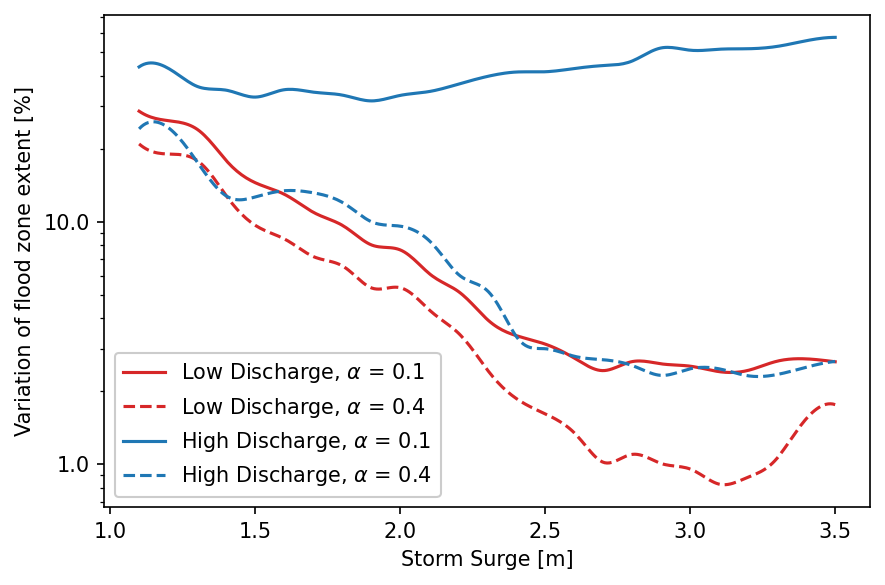

In [154]:
fig, ax = plt.subplots(figsize=(6,4))

# y-axis is zone's area as a percentage of its max value among all scenarios
datetimes = ["2018-09-14 00:00", "2018-09-15 08:00"]
dischargelabels = ["Low Discharge", "High Discharge"]

ax.set_ylabel("Variation of flood zone extent [%]")
for i, datetime in enumerate(datetimes):
    for j, alpha in enumerate([0.1, 0.4]):
        # use less surge_h vals
        plot_df = df_hi_res.copy()
        plot_df = plot_df.loc[datetime]
        plot_df = plot_df[plot_df.alpha_val == alpha]

        T = plot_df.surge_h.values
        power = plot_df.n_trans_norm.values

        # 300 represents number of points to make between T.min and T.max
        xnew = np.linspace(T.min(), T.max(), 300) 

        spl = make_interp_spline(T, power, k=3)  # type: BSpline
        power_smooth = spl(xnew)
        if alpha ==0.4:
            ticker='--'
        elif alpha == 0.1:
            ticker='-'
        if i == 0: # low
            col = 'tab:red'
        elif i==1:
            col = 'tab:blue'
        sc_t = ax.plot(
            xnew,
            # plot_df.n_trans_norm,
            power_smooth,
            ticker,
            c=col,
            # marker="^",
            # facecolors="none",
            # edgecolors="k",
            # linewidth=0.3,
            label=rf"{dischargelabels[i]}, $\alpha$ = {alpha}",
        )

        ax.set(
            # xlim=(-0.75, 1.75),
            # ylim=(0.6, 135),
            xlabel="Storm Surge [m]",
        )

        # ax.set_xticks([0, 1])
        # ax.set_xticklabels(["Low", "High"])

        ax.set_yscale("log")
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.yaxis.get_major_formatter().set_scientific(False)
        ax.yaxis.get_major_formatter().set_useOffset(False)

main_legend = ax.legend(
    loc="best",
    # bbox_to_anchor=(0.5, 1.2),
    # ncol=2,
    framealpha=1,
    markerscale=0.5,
)

fig.tight_layout()

fig.savefig(
    "data_github/tzone_v_surge.png",
    facecolor="w",
    bbox_inches='tight'
)


In [10]:
# ds = gdal.Open('2018091320_11_01.tif')
# band = ds.GetRasterBand(1)
# compound = band.ReadAsArray()
# ds = None

# plt.imshow(
#     compound,
#     vmin=0,
#     vmax=2,
#     cmap=transition_cmap,
#     interpolation='nearest'
#     )
